# CW1 - Multimodal IMDB Analysis with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of films together with their posters in JPEG image format and their overviews in text format from the Internet Movie Database.

![Example](https://i.ibb.co/J3trT62/Screenshot-2024-09-22-214753.png)

You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In addition to this coding exercise, you must write a **2-3 pages** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [1]:
# Enter your module imports here, some modules are already provided
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Processing

Warning: running the following cell can take some time.


In [3]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


        191.67M 100%    1.52MB/s    0:01:59 (xfr#7897, to-chk=0/7898)


In [4]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [5]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [6]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):
  # Convert the images to float32 datatype
  image = tf.cast(image, tf.float32)
  # Resize the images to 64x64 pixels
  image = tf.image.resize(image, [64, 64])
  return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [7]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

posters_train_ds = (
    # Create the dataset from image paths and labels
    tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
     # Improve generalization (better training)
    .shuffle(buffer_size = 1000)
    # Load and decode each image in parallel
    .map(parse_image, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(64)
    # Image preprocessing
    .map(img_process, num_parallel_calls = tf.data.AUTOTUNE)
    # Improves pipeline performance
    .prefetch(tf.data.AUTOTUNE)
)

posters_valid_ds = (
    tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))
    .map(parse_image, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(64)
    .map(img_process, num_parallel_calls = tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


### 1.b. Natural Language processing of the overviews

In [8]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [9]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.

overviews_train_ds = (
    list_overviews_train_ds
    .shuffle(buffer_size = 1000)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

overviews_valid_ds = (
    list_overviews_valid_ds
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [10]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000

encoder = tf.keras.layers.TextVectorization(
    # Max number of unique tokens in the vocabulary
    max_tokens = VOCAB_SIZE,
    # Text to lower case and without punctuation
    standardize = 'lower_and_strip_punctuation',
    # Split the input text into tokens based on whitespaces
    split = 'whitespace',
    # Each token is mapped to a unique integer ID
    output_mode = 'int',
    output_sequence_length = 100
)

# Adapt the encoder on the text data from overviews_train_ds
# We map to just the text. The labels aren't needed for building the vocabulary
encoder.adapt(overviews_train_ds.map(lambda text, label: text))

* Print the first 200 words of the vocabulary you obtained.

In [11]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.

vocab = encoder.get_vocabulary()
print(vocab[:200])

['', '[UNK]', np.str_('a'), np.str_('the'), np.str_('to'), np.str_('of'), np.str_('and'), np.str_('in'), np.str_('his'), np.str_('is'), np.str_('an'), np.str_('with'), np.str_('her'), np.str_('for'), np.str_('on'), np.str_('he'), np.str_('their'), np.str_('who'), np.str_('by'), np.str_('from'), np.str_('when'), np.str_('as'), np.str_('that'), np.str_('after'), np.str_('young'), np.str_('life'), np.str_('they'), np.str_('man'), np.str_('new'), np.str_('him'), np.str_('two'), np.str_('at'), np.str_('are'), np.str_('but'), np.str_('has'), np.str_('into'), np.str_('up'), np.str_('she'), np.str_('love'), np.str_('family'), np.str_('one'), np.str_('out'), np.str_('woman'), np.str_('find'), np.str_('must'), np.str_('be'), np.str_('finds'), np.str_('it'), np.str_('friends'), np.str_('world'), np.str_('story'), np.str_('them'), np.str_('school'), np.str_('where'), np.str_('about'), np.str_('father'), np.str_('group'), np.str_('while'), np.str_('have'), np.str_('girl'), np.str_('years'), np.str_

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [12]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():
  # Input: [(None, 64, 64, 3)]
  inputs = tf.keras.layers.Input(shape = (64, 64, 3), name = "Input")

  # Conv0: (None, 32, 32, 16)
  x = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding = "same", activation = "relu", name = "Conv0")(inputs)
  x = tf.keras.layers.Dropout(0.2, name="Drop1")(x)

  # Conv1: (None, 32, 32, 32)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "Conv1")(x)

  # Conv2: (None, 32, 32, 32)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "Conv2")(x)
  x = tf.keras.layers.Dropout(0.2, name="Drop2")(x)

  # Pool1: (None, 16, 16, 32)
  x = tf.keras.layers.MaxPooling2D(pool_size = 2, name = "Pool1")(x)

  # Conv3: (None, 16, 16, 64)
  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "Conv3")(x)

  # Conv4: (None, 16, 16, 64)
  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "Conv4")(x)
  x = tf.keras.layers.Dropout(0.2, name = "Drop3")(x)

  # Pool2: (None, 8, 8, 64)
  x = tf.keras.layers.MaxPooling2D(pool_size = 2, name = "Pool2")(x)

  # Conv5: (None, 8, 8, 128)
  x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "Conv5")(x)

  # Conv6: (None, 8, 8, 128)
  x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "Conv6")(x)
  x = tf.keras.layers.Dropout(0.2, name = "Drop4")(x)

  # Pool3: (None, 4, 4, 128)
  x = tf.keras.layers.MaxPooling2D(pool_size = 2, name = "Pool3")(x)

  # Flatten: (None, 2048)
  x = tf.keras.layers.Flatten(name = "Flat")(x)

  # FC1: (None, 1024)
  x = tf.keras.layers.Dense(1024, activation = "relu", name = "FC1")(x)
  x = tf.keras.layers.Dropout(0.5, name = "Drop5")(x)

  # FC2: (None, 1024)
  x = tf.keras.layers.Dense(1024, activation = "relu", name = "FC2")(x)
  x = tf.keras.layers.Dropout(0.5, name = "Drop6")(x)

  # Output: (None, 25)
  outputs = tf.keras.layers.Dense(25, activation = "sigmoid", name = "Output")(x)

  model = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model")

  return model

cnn_model = build_cnn_model()


* Print the model summary and confirm it has the same architecture as the one provided.

In [13]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

cnn_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv0 (Conv2D)                  │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop2 (Dropout)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop3 (Dropout)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop4 (Dropout)                 │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (Flatten)                  │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop5 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop6 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 25)             │        25,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [14]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()]
)



### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [15]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

length_vocab = len(encoder.get_vocabulary())
embedder = tf.keras.layers.Embedding(input_dim = length_vocab, output_dim = 256, mask_zero = True)

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [16]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.

lstm_model = tf.keras.Sequential([
    encoder,
    embedder,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout = 0.5, recurrent_dropout = 0.2, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(25, activation = 'sigmoid')
])

lstm_model.build((None,))

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [17]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 512)       │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [18]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

lstm_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()]
)



# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [19]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

checkpoint_cnn_callback = ModelCheckpoint(
    filepath = checkpoint_cnn_filepath,
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = True,
    verbose = 1
)

checkpoint_lstm_callback = ModelCheckpoint(
    filepath = checkpoint_lstm_filepath,
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = True,
    verbose = 1
)


* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [20]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)

### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [21]:
# CodeGrade Tag Ex3a-iii
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object

cnn_history = cnn_model.fit(
    posters_train_ds,
    validation_data = posters_valid_ds,
    epochs = 40,
    callbacks = [checkpoint_cnn_callback, lr_callback]
)


Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.4782 - precision: 0.2210 - recall: 0.3081
Epoch 1: val_loss improved from inf to 0.34946, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - loss: 1.4681 - precision: 0.2218 - recall: 0.3078 - val_loss: 0.3495 - val_precision: 0.5378 - val_recall: 0.3281 - learning_rate: 1.0000e-04
Epoch 2/40
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2917 - precision: 0.4238 - recall: 0.2481
Epoch 2: val_loss improved from 0.34946 to 0.34559, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2915 - precision: 0.4244 - recall: 0.2480 - val_loss: 0.3456 - val_precision: 0.5428 - val_recall: 0.3324 - learning_rate: 1.0000e-04
Epoch 3/40
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2722 - precision: 0.4589 - recall: 0.2279
Epoch 3: val_loss improved from 0.34559 to 0.33837, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [22]:
# CodeGrade Tag Ex3b-i
# Train the model for 20 epochs.

lstm_history = lstm_model.fit(
    overviews_train_ds,
    validation_data = overviews_valid_ds,
    epochs = 20,
    callbacks = [checkpoint_lstm_callback, lr_callback]
)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6724 - precision_1: 0.1047 - recall_1: 0.4107
Epoch 1: val_loss improved from inf to 0.39211, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.6718 - precision_1: 0.1048 - recall_1: 0.4100 - val_loss: 0.3921 - val_precision_1: 0.5423 - val_recall_1: 0.2292 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4939 - precision_1: 0.1528 - recall_1: 0.3054
Epoch 2: val_loss improved from 0.39211 to 0.30958, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 0.4937 - precision_1: 0.1528 - recall_1: 0.3052 - val_loss: 0.3096 - val_precision_1: 0.5423 - val_recall_1: 0.2292 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4345 - precision_1: 0.1864 - recall_1: 0.2752
Epoch 3: val_loss improved from 0.30958 to 0.27690, saving model to /content/checkpoint_lstm.weig

# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

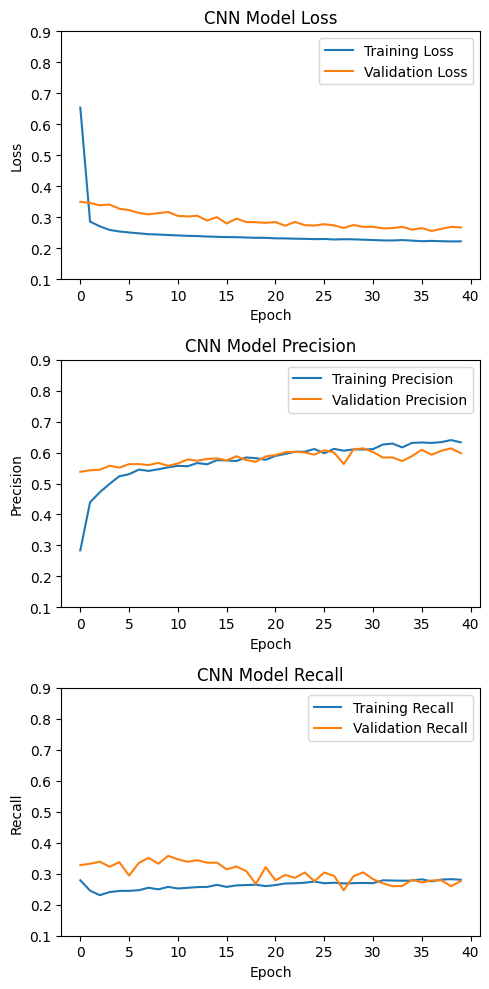

In [23]:
# CodeGrade Tag Ex4a-i

metrics = ['loss', 'precision', 'recall']
y_labels = ['Loss', 'Precision', 'Recall']

# Create figures sharing Y-axis
fig, axs = plt.subplots(len(metrics), 1, figsize = (5, 10), sharey = True)

# One plot per metric
for i, metric in enumerate(metrics):
  axs[i].plot(cnn_history.history[metric], label = f'Training {y_labels[i]}')
  axs[i].plot(cnn_history.history[f'val_{metric}'], label = f'Validation {y_labels[i]}')
  axs[i].set_title(f'CNN Model {y_labels[i]}')
  axs[i].set_xlabel('Epoch')
  axs[i].set_ylabel(y_labels[i])
  axs[i].set_ylim(0.1, 0.9)
  axs[i].legend()

plt.tight_layout()
plt.show()

* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

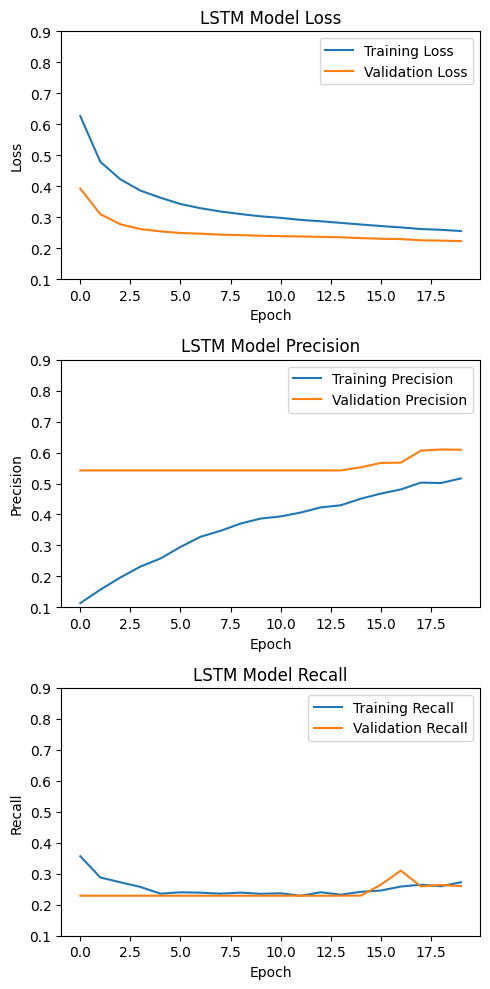

In [24]:
# CodeGrade Tag Ex4b-i

metrics = ['loss', 'precision_1', 'recall_1']

# Create figures sharing Y-axis
fig, axs = plt.subplots(len(metrics), 1, figsize = (5, 10), sharey = True)

# One plot per metric
for i, metric in enumerate(metrics):
    axs[i].plot(lstm_history.history[metric], label = f'Training {y_labels[i]}')
    axs[i].plot(lstm_history.history[f'val_{metric}'], label = f'Validation {y_labels[i]}')
    axs[i].set_title(f'LSTM Model {y_labels[i]}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(y_labels[i])
    axs[i].set_ylim(0.1, 0.9)
    axs[i].legend()

plt.tight_layout()
plt.show()

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

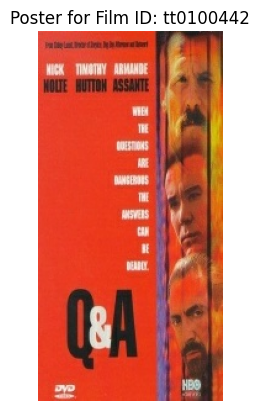

Overview:
When dirty cop Mike shoots a man and plants a gun on him, rookie assistant DA Al gets the case. Something in the Q&A of Mike isn't right. Bodies pile up as Al tries to solve the case.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
**CNN Top-3 Predicted Genres**:
Drama: 0.686
Crime: 0.336
Action: 0.319

**LSTM Top-3 Predicted Genres**:
Drama: 0.511
Comedy: 0.400
Action: 0.219

**Actual Genre(s)**: ['Crime', 'Drama', 'Thriller']
______________________________________________________________



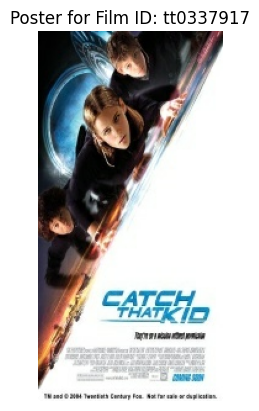

Overview:
A girl and her two friends raid a bank, looking for the money needed for financing the cure of her dying father.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
**CNN Top-3 Predicted Genres**:
Drama: 0.622
Comedy: 0.469
Romance: 0.393

**LSTM Top-3 Predicted Genres**:
Drama: 0.543
Comedy: 0.405
Action: 0.178

**Actual Genre(s)**: ['Comedy', 'Crime']
______________________________________________________________



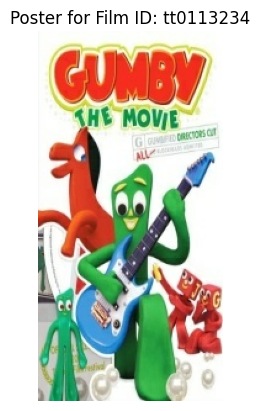

Overview:
In this offshoot of the 1950s "claymation" cartoon series, the crazy Blockheads threaten to ruin Gumby's benefit concert by replacing the entire city of Clokeytown with robots.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
**CNN Top-3 Predicted Genres**:
Comedy: 0.581
Drama: 0.561
Romance: 0.416

**LSTM Top-3 Predicted Genres**:
Drama: 0.444
Comedy: 0.316
Action: 0.307

**Actual Genre(s)**: ['Action', 'Adventure', 'Animation']
______________________________________________________________



In [25]:
# CodeGrade Tag Ex4c

# Load the best weights from the checkpoints of both models
cnn_model.load_weights(checkpoint_cnn_filepath)
lstm_model.load_weights(checkpoint_lstm_filepath)

# 'data_test' contains Id, Genre, Overview,...
num_examples = 3
example_indices = np.random.choice(data_test.index, num_examples, replace = False)
example_films = data_test.loc[example_indices]


def show_poster_overview(film_row, img_loc_base = "/tmp/Multimodal_IMDB_dataset/Images"):
  """
  This function plots the poster and overview of a film.

  Inputs:
    - film_row: film being studied
    - img_loc_base: base location of the images

  Return: None
  """
  film_id = film_row['Id']
  overview = film_row['Overview']

  # Load and decode the image
  image_path = f"{img_loc_base}/{film_id}.jpg"
  image_data = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image_data)

  # Plot the image
  plt.figure()
  plt.imshow(image.numpy())
  plt.axis('off')
  plt.title(f"Poster for Film ID: {film_id}")
  plt.show()

  # Print overview
  print(f"Overview:\n{overview}\n")


# 'genres' is a list of genre names (25 genres).
def predict_cnn(film_row, model, genres, img_loc_base = "/tmp/Multimodal_IMDB_dataset/Images"):
  """
  This function predicts the genres of a film using the CNN model.

  Inputs:
    - film_row: film being studied
    - model: CNN model
    - genres: list of genre names (length = 25)
    - img_loc_base: base location of the images

  Return: 1D array of predictions
  """
  film_id = film_row['Id']
  image_path = f"{img_loc_base}/{film_id}.jpg"

  # Load image
  image_data = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image_data)

  # Preprocess
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [64, 64])

  # Expand dimensions so shape = (1, 64, 64, 3) -> batch of 1
  image = tf.expand_dims(image, 0)

  # Predict
  predictions = model.predict(image)[0]  # shape: (25,)

  return predictions


def predict_lstm(film_row, model):
  """
  This function predicts the genres of a film using the LSTM model.

  Inputs:
    - film_row: film being studied
    - model: LSTM model

  Return: 1D array of predictions
  """
  overview = film_row['Overview']
  # Expand dimensions so shape = (1,) -> batch of 1
  overview_tensor = tf.convert_to_tensor([overview])

  # Predict
  predictions = model.predict(overview_tensor)[0]  # shape: (25,)

  return predictions


def top_k_genres(predictions, genres, k = 3):
  """
  This function returns the top-k genres in descending order of probability.

  Inputs:
    - predictions: 1D array, shape (25,)
    - genres: list of genre names, length 25
    - k: number of top genres to return

  Return: top-k (genre, probability) pairs
  """
  # get indices of top k in descending order
  top_indices = predictions.argsort()[-k:][::-1]
  return [(genres[i], predictions[i]) for i in top_indices]


def get_true_genres(film_row, genres):
  """
  This function gets the true genre of the film.

  Input:
    - film_row: film being studied
    - genres: list of genre names (length = 25)

  Return: list of the film's ground truth genres
  """
  # 25 columns (1 per genre), each one with values 0 or 1
  truth_list = []
  for idx, genre_name in enumerate(genres):
      if film_row[genre_name] == 1:
          truth_list.append(genre_name)
  return truth_list


for idx, film_row in example_films.iterrows():
  show_poster_overview(film_row)

  # CNN predictions
  cnn_preds = predict_cnn(film_row, cnn_model, genres)
  cnn_top3 = top_k_genres(cnn_preds, genres, k=3)

  # LSTM predictions
  lstm_preds = predict_lstm(film_row, lstm_model)
  lstm_top3 = top_k_genres(lstm_preds, genres, k=3)

  # Truth
  actual_genres = get_true_genres(film_row, genres)

  print("**CNN Top-3 Predicted Genres**:")
  for g, prob in cnn_top3:
      print(f"{g}: {prob:.3f}")

  print("\n**LSTM Top-3 Predicted Genres**:")
  for g, prob in lstm_top3:
      print(f"{g}: {prob:.3f}")

  print(f"\n**Actual Genre(s)**: {actual_genres}")
  print("______________________________________________________________\n")